In [1]:
#--- setup and import
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
from datetime import time
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, os.path.abspath(".."))

root = os.path.abspath("..")  # because your notebook is in /notebooks
if root not in sys.path:
    sys.path.append(root)

import src.feature_time as FT
import src.feature_volatility as FVOL
import src.feature_levels as FLEV

reload(FT)
reload(FVOL)
reload(FLEV)






<module 'src.feature_levels' from 'c:\\Users\\user\\Forex_prediction\\src\\feature_levels.py'>

### Read file and import time features related to FX market

In [2]:
# --- Config ---
CSV_PATH = "../data/clean/EUR_USD_COMBINED_2021-2025_4years.csv"   
TS_COL   = "Gmt time"                              #
USE_CYCLICAL = False                               # Importing date related data in cyclical format for better NN performance 
SAVE_FEATHER = "../data/clean/minutes_features_pdf.feather"


In [3]:
# Loading the file
# Currently data consists of 4 years of minute data for EUR/USD
# and has GMT time OHLC and Volume columns
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (1486245, 6)


,Gmt time,Open,High,Low,Close,Volume
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46


In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=["Gmt time"])

# force Volume to be numeric (coerce errors into NaN)
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# now drop NA/zero Volume
before = len(df)
df = df.dropna(subset=["Volume"])
df = df[df["Volume"] > 0]
after = len(df)

print(f"Dropped {before - after} rows ({100*(before-after)/before:.2f}%) due to NA/zero Volume")

# sanity check
print("Unique Volume values (sample):", df["Volume"].unique()[:20])


Dropped 0 rows (0.00%) due to NA/zero Volume
Unique Volume values (sample): [52.95 14.39 17.46 16.03 12.33 28.38 32.48 28.08  9.   14.38 13.38 22.08
 26.02 16.37 16.7  81.06 49.89 19.25 17.33 22.85]


In [5]:
df = FT.add_ny_session_markers(
    df,
    dt_col=TS_COL,
    market_open_local="09:30",
    market_close_local="16:00",
    warmup_minutes=30,
)

In [6]:
def _to_utc(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, utc=False, errors="coerce")
    # if tz-naive, assume it's already UTC; if tz-aware (e.g., America/New_York), convert to UTC
    if getattr(s.dt, "tz", None) is None:
        return s.dt.tz_localize("UTC")
    return s.dt.tz_convert("UTC")


In [7]:
def normalize_session_markers(df_in: pd.DataFrame, dt_col: str = TS_COL, warmup_minutes: int = 30) -> pd.DataFrame:
    d = df_in.copy()
    # Ensure dt_utc
    if "dt_utc" not in d.columns:
        d["dt_utc"] = pd.to_datetime(d[dt_col], utc=True)
    # Build UTC markers from NY-local if missing
    if "ny_open_utc" not in d.columns:
        if "ny_open_ny" in d.columns:
            d["ny_open_utc"] = _to_utc(d["ny_open_ny"])
    if "ny_close_utc" not in d.columns:
        if "ny_close_ny" in d.columns:
            d["ny_close_utc"] = _to_utc(d["ny_close_ny"])
    if "ny_warmup_end_utc" not in d.columns:
        if "ny_warmup_end_ny" in d.columns:
            d["ny_warmup_end_utc"] = _to_utc(d["ny_warmup_end_ny"])
        elif "ny_open_utc" in d.columns:
            d["ny_warmup_end_utc"] = d["ny_open_utc"] + pd.Timedelta(minutes=warmup_minutes)
    # Final sanity: we must have these
    needed = ["ny_open_utc","ny_warmup_end_utc","ny_close_utc","date_us_open"]
    missing = [c for c in needed if c not in d.columns]
    if missing:
        raise KeyError(f"Missing session markers after normalization: {missing}")
    return d

df = normalize_session_markers(df, dt_col=TS_COL, warmup_minutes=30)

In [8]:
# stricter or looser binary flag:
df = FVOL.attach_volatility_score(
    df,
    dt_col="Gmt time",
    atr_lookback=14,
    atr_method="sma",   # or "ema"
    k_atr=1.4,         # raise for stricter (fewer volatile days)
    cap_lo=0.7, cap_hi=1.3
)

# sanity: share of volatile days
pct = df.drop_duplicates("date_us_open")["is_volatile"].mean() * 100
print(f"Volatile days ≈ {pct:.1f}% (k_atr={1.25})")

Volatile days ≈ 14.1% (k_atr=1.25)


In [9]:
reload(FLEV)



df = FLEV.compute_levels(
    df,
    ts_col=TS_COL,
    vwap_mode="rolling_24h",
    vwap_alpha=0.25,
    l1_use=True,
    ib_k=1.0,
    vol_score_col="vol_score",
    vol_scale_l1=True,
    vol_scale_fv=False,
)



In [10]:
import pandas as pd
import numpy as np

# --- 1) Row count ---
print(f"Total rows in df: {len(df):,}")

# --- 2) Distinct FV/L1 values per US day in August with start times ---

# pick level columns that actually exist in df
candidate_cols = [
    "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
    "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active"
]
level_cols = [c for c in candidate_cols if c in df.columns]
if not level_cols:
    raise ValueError("No *_active level columns found. Make sure compute_levels() has been run.")

# we’ll use UTC timestamps for start times
if "dt_utc" not in df.columns:
    raise ValueError("dt_utc column is required.")

# restrict to August (any year)
aug = df[df["dt_utc"].dt.month == 8].copy()
if aug.empty:
    print("No August data found.")
else:
    # ensure date_us_open is datetime (date) for grouping
    aug["date_us_open"] = pd.to_datetime(aug["date_us_open"])

    records = []
    for (day), g in aug.sort_values("dt_utc").groupby("date_us_open", sort=True):
        # within each US day, find segments where a level changes value
        g = g.sort_values("dt_utc")
        for col in level_cols:
            # change points for this column within the day
            mask = g[col].ne(g[col].shift())
            starts = g.loc[mask, ["dt_utc", col]]
            # record each distinct value with its first start time
            for _, row in starts.iterrows():
                val = row[col]
                # skip NaNs (can happen pre-init)
                if pd.isna(val):
                    continue
                records.append({
                    "date_us_open": day.date(),
                    "level": col,
                    "value": float(val),
                    "start_time_utc": row["dt_utc"]
                })

    # tidy DataFrame with one row per (day, level, distinct value) and its start time
    august_levels = pd.DataFrame.from_records(records).sort_values(
        ["date_us_open","level","start_time_utc"]
    ).reset_index(drop=True)

    # show a quick preview
    print("\nDistinct FV/L1 values per US trading day in August (first start times, UTC):")
    display_cols = ["date_us_open","level","value","start_time_utc"]
    print(august_levels[display_cols].head(20))

    # --- Optional: per-day counts of distinct values for each level ---
    counts = (
        august_levels
        .groupby(["date_us_open","level"])["value"]
        .nunique()
        .rename("distinct_values")
        .reset_index()
        .pivot(index="date_us_open", columns="level", values="distinct_values")
        .fillna(0).astype(int)
        .sort_index()
    )
    print("\nCount of distinct values per day (August):")
    print(counts)


Total rows in df: 1,486,245

Distinct FV/L1 values per US trading day in August (first start times, UTC):
   date_us_open               level     value            start_time_utc
0    2021-08-16  FV_high_adj_active  1.178401 2021-08-16 14:00:00+00:00
1    2021-08-16   FV_low_adj_active  1.177321 2021-08-16 14:00:00+00:00
2    2021-08-16   FV_mid_adj_active  1.177861 2021-08-16 14:00:00+00:00
3    2021-08-16        L1_dn_active  1.176241 2021-08-16 14:00:00+00:00
4    2021-08-16    L1_mid_dn_active  1.176781 2021-08-16 14:00:00+00:00
5    2021-08-16    L1_mid_up_active  1.178941 2021-08-16 14:00:00+00:00
6    2021-08-16        L1_up_active  1.179481 2021-08-16 14:00:00+00:00
7    2021-08-17  FV_high_adj_active  1.178401 2021-08-17 04:00:00+00:00
8    2021-08-17  FV_high_adj_active  1.174606 2021-08-17 14:00:00+00:00
9    2021-08-17   FV_low_adj_active  1.177321 2021-08-17 04:00:00+00:00
10   2021-08-17   FV_low_adj_active  1.173776 2021-08-17 14:00:00+00:00
11   2021-08-17   FV_mid_adj_a

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_levels_styled(
    df,
    start_date=None, end_date=None, ndays=3, tz="UTC",
    show_updates=True,
):
    """
    Plot Close with FV/L1 active levels using requested colors & styling.
    - FV boundaries: green
    - L1 (outer): purple
    - Midway (between L1 and FV): blue
    - FV zone fill: light gray
    - FV halves: faint lines
    """
    x = df.copy()
    x["dt_utc"] = pd.to_datetime(x["dt_utc"], utc=True)

    # window by date_us_open
    if start_date is not None:
        start_date = pd.to_datetime(start_date).date()
        if end_date is None:
            end_date = (pd.to_datetime(start_date) + pd.Timedelta(days=ndays-1)).date()
        else:
            end_date = pd.to_datetime(end_date).date()
        mask = (x["date_us_open"] >= start_date) & (x["date_us_open"] <= end_date)
        x = x.loc[mask]

    if x.empty:
        print("No data in selected window.")
        return

    # x-axis
    xaxis = x["dt_utc"].dt.tz_convert("America/New_York") if tz=="America/New_York" else x["dt_utc"]

    # required columns (use *_active so levels carry across the day)
    need = [
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active"
    ]
    have = [c for c in need if c in x.columns]
    if len(have) < 3:
        raise ValueError("Missing active level columns; run compute_levels first.")

    fig, ax = plt.subplots(figsize=(14,6))

    # price
    ax.plot(xaxis, x["Close"], lw=1.0, color="black", label="Close", zorder=3)

    # ----- FV zone fill (light gray) -----
    if {"FV_low_adj_active","FV_high_adj_active"} <= set(have):
        ax.fill_between(
            xaxis, x["FV_low_adj_active"], x["FV_high_adj_active"],
            alpha=0.10, color="gray", label="FV zone", zorder=1
        )

    # ----- FV boundaries (green) -----
    if "FV_low_adj_active" in have:
        ax.plot(xaxis, x["FV_low_adj_active"], lw=1.3, color="green", label="FV_low", zorder=2)
    if "FV_high_adj_active" in have:
        ax.plot(xaxis, x["FV_high_adj_active"], lw=1.3, color="green", label="FV_high", zorder=2)

    # FV mid (keep visible, not emphasized)
    if "FV_mid_adj_active" in have:
        ax.plot(xaxis, x["FV_mid_adj_active"], lw=1.0, color="green", alpha=0.35, label="FV_mid", zorder=2)

    # FV halves (fainter)
    if "FV_half_dn_active" in x.columns:
        ax.plot(xaxis, x["FV_half_dn_active"], lw=1.0, color="green", alpha=0.25, label="FV_half_dn", zorder=2)
    if "FV_half_up_active" in x.columns:
        ax.plot(xaxis, x["FV_half_up_active"], lw=1.0, color="green", alpha=0.25, label="FV_half_up", zorder=2)

    # ----- L1 (purple) -----
    if "L1_dn_active" in have:
        ax.plot(xaxis, x["L1_dn_active"], lw=1.2, color="purple", label="L1_dn", zorder=2)
    if "L1_up_active" in have:
        ax.plot(xaxis, x["L1_up_active"], lw=1.2, color="purple", label="L1_up", zorder=2)

    # Midway lines between L1 and FV (blue)
    if "L1_mid_dn_active" in have:
        ax.plot(xaxis, x["L1_mid_dn_active"], lw=1.1, color="blue", label="Mid_dn (L1↔FV)", zorder=2)
    if "L1_mid_up_active" in have:
        ax.plot(xaxis, x["L1_mid_up_active"], lw=1.1, color="blue", label="Mid_up (L1↔FV)", zorder=2)

    # Optional: show vertical update markers at warmup end
    if show_updates and "ny_warmup_end_utc" in x.columns:
        ups = (x[["date_us_open","ny_warmup_end_utc"]]
               .drop_duplicates("date_us_open")
               .sort_values("date_us_open"))
        ups_x = ups["ny_warmup_end_utc"].dt.tz_convert("America/New_York") if tz=="America/New_York" else ups["ny_warmup_end_utc"]
        for t in ups_x:
            ax.axvline(t, color="gray", alpha=0.3, lw=0.8, linestyle="--")
        if len(ups):
            last_range = f"{ups['date_us_open'].min()} → {ups['date_us_open'].max()}"
        else:
            last_range = ""
    else:
        last_range = ""

    # cosmetics
    title_range = f" ({start_date} → {end_date}, shown in {tz})" if start_date is not None else f" (shown in {tz})"
    ax.set_title("Price + Levels" + title_range)
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="upper left", ncol=3, fontsize=8)

    plt.show()


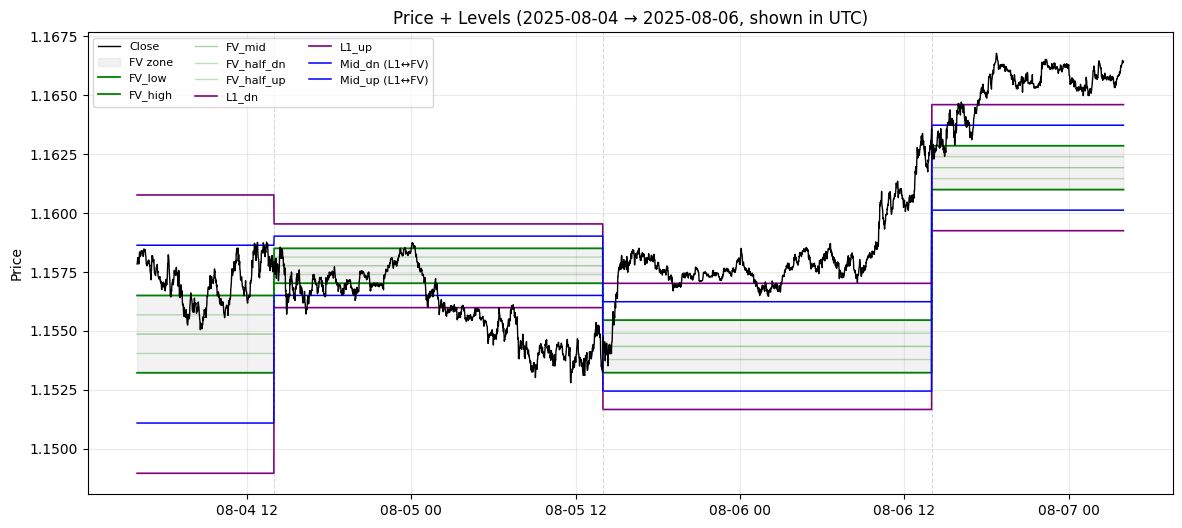

No data in selected window.


In [26]:
# 3 days starting Aug 21, 2021 (UTC x-axis)
plot_levels_styled(df, start_date="2025-08-04", ndays=3, tz="UTC")

# Custom range with NY x-axis and update markers
plot_levels_styled(df, start_date="2025-08-23", end_date="2021-08-25",
                   tz="America/New_York", show_updates=True)


In [16]:
updates = df[["date_us_open","ny_open_utc","ny_warmup_end_utc"]].drop_duplicates()
print(updates.head(10))


      date_us_open               ny_open_utc         ny_warmup_end_utc
0       2021-08-15 2021-08-15 13:30:00+00:00 2021-08-15 14:00:00+00:00
238     2021-08-16 2021-08-16 13:30:00+00:00 2021-08-16 14:00:00+00:00
1629    2021-08-17 2021-08-17 13:30:00+00:00 2021-08-17 14:00:00+00:00
3059    2021-08-18 2021-08-18 13:30:00+00:00 2021-08-18 14:00:00+00:00
4490    2021-08-19 2021-08-19 13:30:00+00:00 2021-08-19 14:00:00+00:00
5909    2021-08-20 2021-08-20 13:30:00+00:00 2021-08-20 14:00:00+00:00
6922    2021-08-22 2021-08-22 13:30:00+00:00 2021-08-22 14:00:00+00:00
7316    2021-08-23 2021-08-23 13:30:00+00:00 2021-08-23 14:00:00+00:00
8728    2021-08-24 2021-08-24 13:30:00+00:00 2021-08-24 14:00:00+00:00
10121   2021-08-25 2021-08-25 13:30:00+00:00 2021-08-25 14:00:00+00:00
